# Ada Final Project - EDA

In [3]:
from collections import Counter
from scripts.allsides import strip_url
import itertools
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore
import gensim.corpora as corpora
import gensim
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import syllables
import spacy
import re
import pickle
import random
from tqdm.notebook import tqdm
import kaleido

import sklearn
import pyLDAvis.gensim_models
import pandas as pd
import numpy as np

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download([
    "names",
    "stopwords",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",
])

sp = spacy.load('en_core_web_sm')
from IPython.display import display, Markdown



%matplotlib inline

[nltk_data] Downloading package names to /Users/daynex/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daynex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/daynex/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daynex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/daynex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
PATH_TO_FILE = 'data/hillary-and-trump-quotes-2016.json.bz2'

JEKYLL_PLOTS_PATH = "docs/_includes/plots/"

CHUNK_SIZE = 100_000

RANDOM_SAMPLE_SIZE = 3_000

SEED = 92813

HC = "Hillary Clinton"
DT = "Donald Trump"

red = px.colors.qualitative.Plotly[1]
blue = px.colors.qualitative.Plotly[0]

In [5]:
FIG_SAVE_TO_DISK = False


def save_fig(fig, file_name, save_to_disk: bool):
    """
    Convert a plotly figure both to HTML and to PNG, and save to Jekyll local plots path
    :param fig: plotly figure object
    :param file_name: string - name of the output file, *without extension*
    :param save_to_disk: bool - Specifies if file should be saved to to disk or not.
    """
    if save_to_disk:
        html_file = JEKYLL_PLOTS_PATH + file_name + ".html"
        fig.write_html(html_file, include_plotlyjs=False,
                       full_html=False, default_width=600, default_height=400)

In [6]:
SHOW_MODE = "svg"


def save_and_show(fig, file_name, save_to_disk: bool, show_mode: str):
    """
    Convert a plotly figure both to HTML and to PNG, and save to Jekyll local plots path
    Then display it, either rendering the HTML or the PNG
    :param fig: plotly figure object
    :param file_name: string - name of the output file, *without extension*
    :param save_to_disk: bool - Specifies if file should be saved to to disk or not.
    :param show_from_disk: str - Which format to show the figure by. "" for html, also supports svg and png.
    """
    save_fig(fig, file_name, save_to_disk=save_to_disk)
    fig.show(renderer=show_mode)

## 1. Load Data

### Initial Data Extraction

For reference we include the code we executed on Google Colab to extract all quotes by **Hillary Clinton** and **Donald Trump** during the **year 2016** from the Quotebank dataset. This was a one time operation, which is why we did it outside of this notebook. All other algorithms we apply to the data will be/have been possibly iterated on for improvement, which is where the notebook format comes in handy.

```python
PATH_TO_FILE = '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2'
PATH_TO_OUT = '/content/drive/MyDrive/hillary-and-trump-quotes-2016.json.bz2'

SPEAKER_NAMES = ['Hillary Clinton', 'Donald Trump']

hits = 0

with bz2.open(PATH_TO_FILE, 'rb') as s_file:
    with bz2.open(PATH_TO_OUT, 'wb') as d_file:

        for instance in s_file:

            instance = json.loads(instance)
            speaker = instance['speaker']

            if any(map(speaker.__contains__, desired_speakers)):

                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

                hits += 1


print(f"Hits: {hits}")
```

In [7]:
# chunksize=CHUNK_SIZE)
df_1 = pd.read_json(PATH_TO_FILE, lines=True, compression='bz2')

In [8]:
display(df_1.head())

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,[Q6294],2016-07-11 17:26:06,1,"[[Hillary Clinton, 0.9025], [None, 0.0975]]",[http://www.breitbart.com/tech/2016/07/11/hill...,E
1,2016-07-28-001820,a little bit personally.,Donald Trump,"[Q22686, Q27947481]",2016-07-28 10:26:34,2,"[[Donald Trump, 0.7921], [None, 0.1568], [Bria...",[http://lcsun-news.com/story/news/politics/onp...,E
2,2016-08-27-001626,A vote for Clinton is a vote for open borders.,Donald Trump,"[Q22686, Q27947481]",2016-08-27 23:31:11,1,"[[Donald Trump, 0.8488], [None, 0.1176], [Hill...",[http://whotv.com/2016/08/27/trump-takes-stage...,E
3,2016-05-24-003322,"Additionally, all sorts of `horrors' had been ...",Donald Trump,"[Q22686, Q27947481]",2016-05-24 08:59:38,1,"[[Donald Trump, 0.6887], [None, 0.2613], [Matt...",[http://nmpolitics.net/index/2016/05/do-the-up...,E
4,2016-08-20-002872,AMERICA is once again at a moment of reckoning...,Hillary Clinton,[Q6294],2016-08-20 06:02:42,1,"[[Hillary Clinton, 0.9679], [None, 0.0321]]",[http://asianjournal.com/lifestyle/dnc-chronic...,E


In [9]:
#
# Produces a sample from the entire dataset as well one for each candidate
#
def get_df_samples(df, sample_size=RANDOM_SAMPLE_SIZE):

    sample = df.sample(n=sample_size, random_state=SEED)

    dt_sample = df[df['speaker'] == 'Donald Trump'].sample(
        n=sample_size, random_state=SEED)
    hc_sample = df[df['speaker'] == 'Hillary Clinton'].sample(
        n=sample_size, random_state=SEED)

    return sample, dt_sample, hc_sample

## 2. Enhance Data

In [10]:
df_2 = df_1.copy()
#
# Extract first (highest) proba score, which is the one assigned to the "speaker" and place it in the proba column.
#
df_2['proba'] = df_2['probas'].apply(lambda probas: float(probas[0][1]))

#
# Only keep the date and ignore the time
#
df_2['date'] = pd.to_datetime(df_2['date'])

df_2.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba
0,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,[Q6294],2016-07-11 17:26:06,1,"[[Hillary Clinton, 0.9025], [None, 0.0975]]",[http://www.breitbart.com/tech/2016/07/11/hill...,E,0.9025
1,2016-07-28-001820,a little bit personally.,Donald Trump,"[Q22686, Q27947481]",2016-07-28 10:26:34,2,"[[Donald Trump, 0.7921], [None, 0.1568], [Bria...",[http://lcsun-news.com/story/news/politics/onp...,E,0.7921
2,2016-08-27-001626,A vote for Clinton is a vote for open borders.,Donald Trump,"[Q22686, Q27947481]",2016-08-27 23:31:11,1,"[[Donald Trump, 0.8488], [None, 0.1176], [Hill...",[http://whotv.com/2016/08/27/trump-takes-stage...,E,0.8488
3,2016-05-24-003322,"Additionally, all sorts of `horrors' had been ...",Donald Trump,"[Q22686, Q27947481]",2016-05-24 08:59:38,1,"[[Donald Trump, 0.6887], [None, 0.2613], [Matt...",[http://nmpolitics.net/index/2016/05/do-the-up...,E,0.6887
4,2016-08-20-002872,AMERICA is once again at a moment of reckoning...,Hillary Clinton,[Q6294],2016-08-20 06:02:42,1,"[[Hillary Clinton, 0.9679], [None, 0.0321]]",[http://asianjournal.com/lifestyle/dnc-chronic...,E,0.9679


### Sample of enhanced, but dirty data

In [11]:
sample, dt_sample, hc_sample = get_df_samples(df_2)

## 3. EDA and  Data Cleaning

In [12]:
df_3 = df_2.copy()

We are only interested in quotes by **Hillary Clinton** and **Donald Trump** during the **year 2016**, specifically from 01/01/2016 - 01/01/2017. The subset loaded only contains the Quotebank quotes which have one (or both) of them as a possible speaker in the _speaker_ columns list and that lie in the specified time frame.

Since the dataset was obtained using a ML model to extract and assign the quotes there will most likely be quotes which are faulty and quotes which have been assigned to the wrong speaker. The goal of the data cleaning is to remove such data points so that we can focus on working with as good data as possible.

We must specify what makes a quote faulty and motivate this so that we remove as many bad quotes as possible while not removing any or as little actually correct quotes as possible.

### General EDA

In [13]:
blue_patch = mpatches.Patch(color='blue', alpha=0.4, label='Hillary Clinton')
red_patch = mpatches.Patch(color='red', alpha=0.4, label='Donald Trump')

In [14]:
blue_patch = mpatches.Patch(color='blue', alpha=0.4, label='Hillary Clinton')
red_patch = mpatches.Patch(color='red', alpha=0.4, label='Donald Trump')

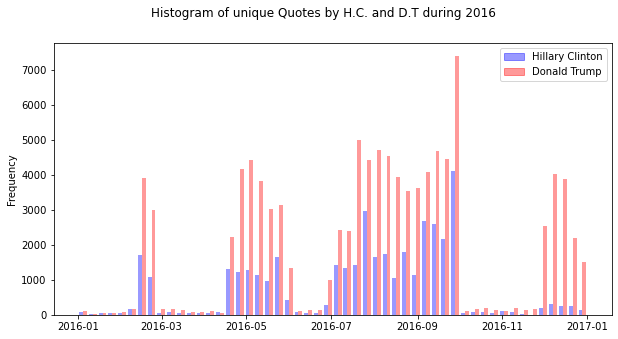

<Figure size 432x288 with 0 Axes>

In [15]:
def quotes_hist_split_rough(df, weighted=False, use_log=False, n_bins=52): # One per day (366 days in 2016)

    fig, ax = plt.subplots(figsize=(10, 5))

    fig.suptitle("Histogram of {} Quotes by H.C. and D.T during 2016".format(
        'all' if weighted else 'unique'))

    df_hc = df[df['speaker'] == 'Hillary Clinton']
    df_dt = df[df['speaker'] == 'Donald Trump']

    ax.hist(
        [df_hc['date'], df_dt['date']],
        weights=([df_hc['numOccurrences'], df_dt['numOccurrences']]
                 if weighted else None),
        bins=n_bins,
        color=["blue", "red"],
        alpha=0.4,
        log=use_log
    )

    ax.set_ylabel("Frequency" + (' (log)' if use_log else ''))
    ax.legend(handles=[blue_patch, red_patch])

    plt.show()
    plt.clf()


quotes_hist_split_rough(df_3)

![Histogram of all (Quotebank) Quotes in 2016](assets/histogram-quotebank-quotes-2016.png)

After seing that there are suspicious periods of no or barely any quotes in the graph above we went back to the unfiltered (whole) dataset and plotted the distribution of all quote dates. The result can be seen in the graph above (computed in Google Colab) and suggests that this pattern is also present in the entire dataset, suggesting that this at least should not stem from a faulty filtration.

**Note: The sharp dips are due to data outages on behalf of Spinn3r (From: Quotebank - A Corpus of Quotations from a Decade of News.pdf)**

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba
129227,2016-09-01-072908,"knew what he signed up for,",President Donald Trump,[Q22686],2016-09-01 16:27:38,11084,"[[President Donald Trump, 0.5416], [None, 0.15...",[http://www.vocativ.com/355767/former-player-a...,E,0.5416
7308,2016-07-26-085806,"Russia, if you're listening -- I hope you're a...",Donald Trump,"[Q22686, Q27947481]",2016-07-26 03:43:04,6335,"[[Donald Trump, 0.3961], [None, 0.2975], [Pres...",[https://gma.yahoo.com/democratic-national-con...,E,0.3961
25410,2016-09-10-001045,a basket of deplorables.,Donald Trump,"[Q22686, Q27947481]",2016-09-10 08:41:50,3099,"[[Donald Trump, 0.3467], [Hillary Clinton, 0.2...",[http://www.ozy.com/presidential-daily-brief/p...,E,0.3467
85071,2016-07-20-027919,have fulfilled their obligations to us.,Donald Trump,"[Q22686, Q27947481]",2016-07-20 00:00:00,2915,"[[Donald Trump, 0.5767], [None, 0.2264], [Mela...",[http://ktar.com/story/1188950/trump-hedges-on...,E,0.5767
60334,2016-02-23-083498,load it up with some bad dudes.,President Donald Trump,[Q22686],2016-02-23 22:02:00,2407,"[[President Donald Trump, 0.5797], [None, 0.21...",[http://feeds.reuters.com/~r/reuters/USVideoLa...,E,0.5797


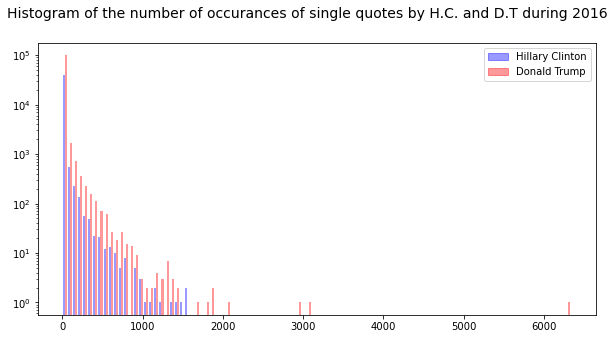

<Figure size 432x288 with 0 Axes>

In [16]:
#
# Histogram of all occurences per quote grouped by Trump and CLinton for each day in 2016
#
def occ_hist_split(df, n_bins=100, use_log=True):

    fig, ax = plt.subplots(figsize=(10, 5))

    fig.suptitle(
        "Histogram of the number of occurances of single quotes by H.C. and D.T during 2016", fontsize=14)

    df_hc = df[df['speaker'] == 'Hillary Clinton']
    df_dt = df[df['speaker'] == 'Donald Trump']
    ax.hist([df_hc['numOccurrences'], df_dt['numOccurrences']],
            log=use_log, bins=n_bins, color=["blue", "red"], alpha=0.4)

    ax.legend(handles=[blue_patch, red_patch])

    plt.show()
    plt.clf()


df_test = df_3.sort_values('numOccurrences', ascending=False)

display(df_test.head())
print()

occ_hist_split(df_test)

Check for duplictates in regards to the quote content

In [17]:
df_3[df_3.duplicated(subset=['quotation'], keep=False)]

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba


No duplicate quote, hence all quotations which have been used by multiple sources are indicated by the `numOccurances` column and further detailed by the list in the `urls` column.

### Proba assigned to Quotes

#### Investigation

**Motivation**

Certain quotes that the model assigned to Trump and Clinton have very low probabilities to actually be quotes by them inside of the text as by the computation of the model. We want to learn about the distribution of the probability of the assigned quotes so that we can take a decision on if and when to filter out certain quotes due to a too low probability computed for them by the model.

**Distribution of the Proba**

Here we plot the distribution of a sample of 1,000 Trump and 1,000 Clinton quotes respectively. The reason we sample seperatley is given the fact that we want to ensure a large enough sample pool for both candidates, which is needed since there are more quotes assigned to Trump than Clinton. We also plot the two seperatly to make sure that we do not miss any differences in the dsitribution.

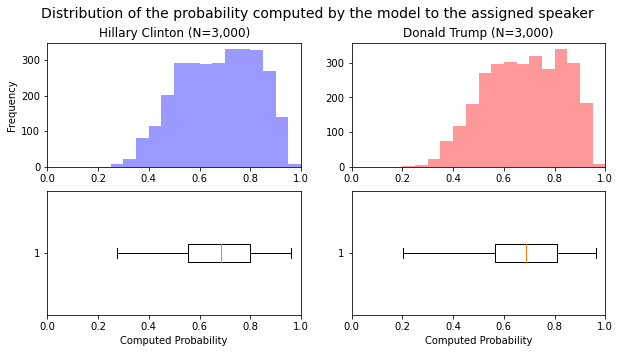

Hillary Clinton Summary Statistics


count    3000.000000
mean        0.674941
std         0.149986
min         0.275500
25%         0.556000
50%         0.683900
75%         0.799650
max         0.961800
Name: proba, dtype: float64


Donald Trump Summary Statistics


count    3000.000000
mean        0.674941
std         0.149986
min         0.275500
25%         0.556000
50%         0.683900
75%         0.799650
max         0.961800
Name: proba, dtype: float64

<Figure size 432x288 with 0 Axes>

In [18]:
def probas_hist_split(df, on_sample=True, n_bins=20):

    if on_sample:
        _, dt_df, hc_df = get_df_samples(df)
    else:
        dt_df = df[df['speaker'] == 'Donald Trump']
        hc_df = df[df['speaker'] == 'Hillary Clinton']

    proba_bins = [round((1 / n_bins), 2) * i for i in range(0, n_bins + 1)]

    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    fig.suptitle(
        "Distribution of the probability computed by the model to the assigned speaker", fontsize=14)

    axs[0, 0].set(xlim=(0, 1))
    axs[0, 1].set(xlim=(0, 1))

    axs[0, 0].hist(hc_df['proba'], bins=proba_bins, color='blue', alpha=0.4)
    axs[0, 1].hist(dt_df['proba'], bins=proba_bins, color='red', alpha=0.4)

    axs[1, 0].set(xlim=(0, 1))
    axs[1, 1].set(xlim=(0, 1))

    axs[1, 0].boxplot(hc_df['proba'], vert=False)
    axs[1, 1].boxplot(dt_df['proba'], vert=False)

    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].title.set_text('Hillary Clinton (N={:,})'.format(len(hc_df)))

    axs[0, 1].title.set_text('Donald Trump (N={:,})'.format(len(dt_df)))

    axs[1, 1].set_xlabel('Computed Probability')
    axs[1, 0].set_xlabel('Computed Probability')

    plt.show()
    plt.clf()


#
# Run on a random sample of 1,0000 quotes per speaker (for speed)
#
example = df_3.copy()
probas_hist_split(example, on_sample=True)


print("Hillary Clinton Summary Statistics")
display(hc_sample['proba'].describe())
print()
print("Donald Trump Summary Statistics")
display(hc_sample['proba'].describe())

From plotting the distribution of probabilities which the model computed to the quotes it assigned to Trump and Hillary respectively we could now act in at least 3 ways:

1. Remove any quote which is below the min probability minus a small margin because they are outliers. **I.e. Only Remove outliers.**

2. Set the cutoff even higher because we decide to consider quotes with, ex. less than 0.4 probability assigned to the candidate being the speaker too weak to consider it in further analysis.

3. A further possibility could be to remove quotes, where the next best speaker assigned has a similair/close probability compare to the number one.

   Example: `[ [ 'Trump', 0.41 ], [ 'Kanye West', 0.39 ], ...]`

**TODO for later:** What should we do? What is scientifically sound? How do we motivate it?



**Filtering out datapoints with too low probability**

#### Filter Function

Result of filter with threshold: 0.7

Removed 76,628 datapoints or 53.17% of the original dataset.



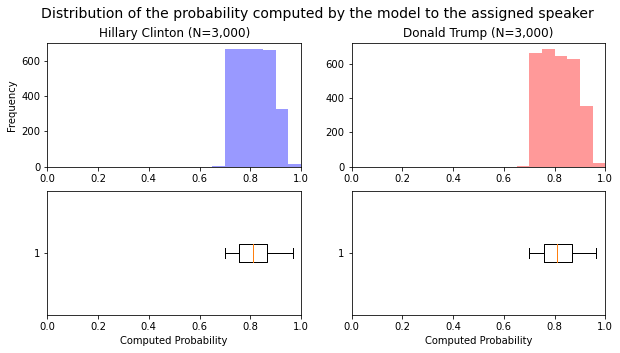

<Figure size 432x288 with 0 Axes>

In [19]:
#
# Function to remove quote with proba below a threshold.
#
def remove_low_proba_quotes(df, threshold):
    return df[df['proba'] >= threshold].copy()


example = df_3.copy()

example_threshold = 0.7

example = remove_low_proba_quotes(df_3, threshold=example_threshold)

n_removed_lines = len(df_3) - len(example)
percentage_removed = (n_removed_lines / len(df_3)) * 100

print("Result of filter with threshold: {:}\n".format(example_threshold))
print("Removed {:,.0f} datapoints or {:,.2f}% of the original dataset.\n".format(
    n_removed_lines, percentage_removed))

probas_hist_split(example, on_sample=True)

### Who are the speakers?

#### Investigation

In [20]:
def display_speaker_breakdown(df):
    display(df.groupby(['speaker']).count().sort_values(
        'quotation', ascending=False)['quotation'])


#
# Check out the unique speakers in our dataset
#
display_speaker_breakdown(df_3)

speaker
Donald Trump              102351
Hillary Clinton            39950
President Donald Trump      1306
Donald Trump Jr. .           359
president Donald Trump        78
Donald Trump , Jr. .          46
Donald Trump Jr               36
PRESIDENT Donald Trump         1
Name: quotation, dtype: int64

We see that our intial, rough, extraction algorithm extracted quotes by Trump's son and also some where Trump is titled "President". We assign will assign the "president" tittled quotes to Trump and filter out the  ones about his son.

#### Re-assignment Function

In [21]:
#
# Function to assign quotes, where Trump is titlte "President" to his speaker name.
#
def assign_quotes_for_president_dt_to_dt(df):

    df = df.replace(
        to_replace=['president Donald Trump',
                    'PRESIDENT Donald Trump', 'President Donald Trump'],
        value='Donald Trump'
    )

    return df


example = df_3.copy()
example = assign_quotes_for_president_dt_to_dt(df_3)

n_removed_lines = len(df_3) - len(example)
percentage_removed = (n_removed_lines / len(df_3)) * 100

print("Result of filter:\n")
print("Removed {:,.0f} datapoints or {:,.2f}% of the original dataset.\n".format(
    n_removed_lines, percentage_removed))


display_speaker_breakdown(example)

Result of filter:

Removed 0 datapoints or 0.00% of the original dataset.



speaker
Donald Trump            103736
Hillary Clinton          39950
Donald Trump Jr. .         359
Donald Trump , Jr. .        46
Donald Trump Jr             36
Name: quotation, dtype: int64

#### Filter Function

In [22]:
#
# Removes quotes by different speakers
#
def only_keep_dt_and_hc_quotes(df):
    return df[df['speaker'].isin(['Hillary Clinton', 'Donald Trump'])]


example = only_keep_dt_and_hc_quotes(example)

print("Result of filter: \n")
display_speaker_breakdown(example)

n_removed_lines = len(df_3) - len(example)
percentage_removed = (n_removed_lines / len(df_3)) * 100

print("\n")

print("Removed {:,.0f} datapoints or {:,.2f}% of the original dataset".format(
    n_removed_lines, percentage_removed))

Result of filter: 



speaker
Donald Trump       103736
Hillary Clinton     39950
Name: quotation, dtype: int64



Removed 441 datapoints or 0.31% of the original dataset


### "Nonsense" content

**TODO**: We should ideally check for the quality of the quotes. There are certainly some faulty quotes and maybe even gibberish in the dataset but it is hopefully very limited in scope. We should nonetheless attempt to look for faulty/gibbersih quotes which were extracted by the model and remove them.

### The "data-gap"

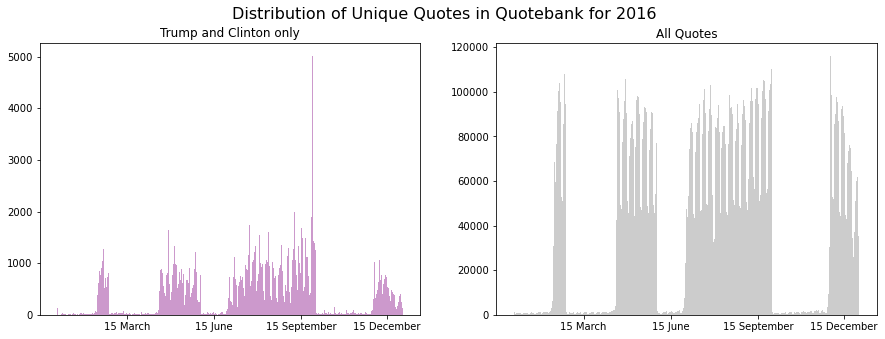

<Figure size 432x288 with 0 Axes>

In [23]:
# Unique Quotes per day of entire 2016 Quotebbank
df_original_hist = pd.read_csv(
    "data/unique-quotes-per-day-2016.csv")[['date', 'n_unique_quotes']]
df_original_hist['date'] = pd.to_datetime(df_original_hist['date'])

fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Distribution of Unique Quotes in Quotebank for 2016", fontsize=16)

left_ax.set_title("Trump and Clinton only")
left_ax.hist(df_3['date'], bins=366, color='purple', alpha=0.4)

right_ax.set_title("All Quotes")
right_ax.hist(df_original_hist['date'],
              weights=df_original_hist['n_unique_quotes'], bins=366, color='gray', alpha=0.4)

xticks = ['2016-03-15', '2016-06-15', '2016-09-15', '2016-12-15']
xticks_labels = ['15 March', '15 June', '15 September', '15 December']

left_ax.set_xticks(xticks)
left_ax.set_xticklabels(xticks_labels)

right_ax.set_xticks(xticks)
right_ax.set_xticklabels(xticks_labels)

plt.show()

plt.clf()

#### Patches for the Visualisations

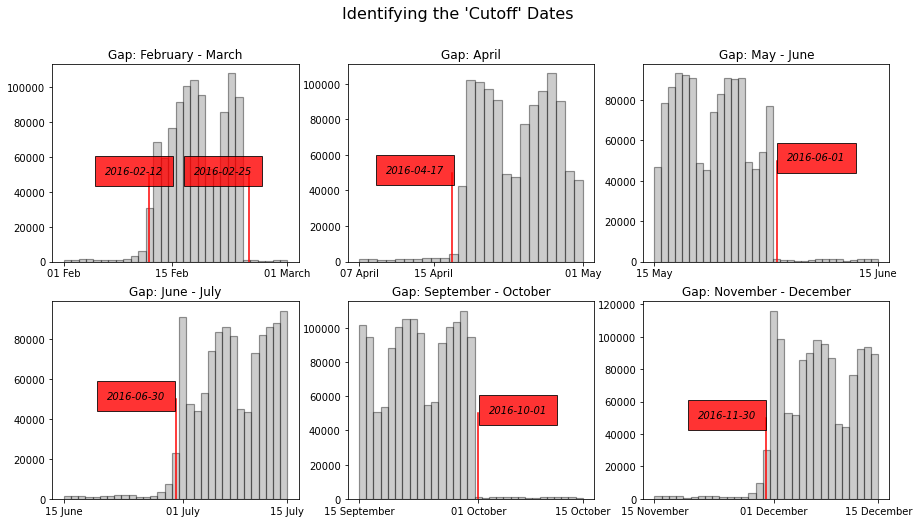

<Figure size 432x288 with 0 Axes>

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

fig.suptitle("Identifying the 'Cutoff' Dates", fontsize=16)

#
# First Gap
#
axs[0, 0].set_title("Gap: February - March")

gap = df_original_hist[(df_original_hist['date'] >= '2016-02-01')
                       & (df_original_hist['date'] <= '2016-03-01')]
gap_days = len(gap)

_, bins, patches = axs[0, 0].hist(gap['date'], weights=gap['n_unique_quotes'],
                                  bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-02-01', '2016-02-15', '2016-03-01']
xticks_labels = ['01 Feb', '15 Feb', '01 March']

axs[0, 0].set_xticks(xticks)
axs[0, 0].set_xticklabels(xticks_labels)

cutoff_left = '2016-02-12'
v_l = mlines.Line2D([cutoff_left, cutoff_left], [0, 50_000], color='red')
axs[0, 0].add_line(v_l)
axs[0, 0].text(bins[6]-0.5, 50_000,  cutoff_left, style='italic',
               bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

cutoff_right = '2016-02-25'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0, 50_000], color='red')
axs[0, 0].add_line(v_l)
axs[0, 0].text(bins[18]-0.5, 50_000,  cutoff_right, style='italic',
               bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Second Gap
#
axs[0, 1].set_title("Gap: April")

gap = df_original_hist[(df_original_hist['date'] >= '2016-04-07')
                       & (df_original_hist['date'] <= '2016-05-01')]
gap_days = len(gap)

_, bins, patches = axs[0, 1].hist(gap['date'], weights=gap['n_unique_quotes'],
                                  bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-04-07', '2016-04-15', '2016-05-01']
xticks_labels = ['07 April', '15 April', '01 May']

axs[0, 1].set_xticks(xticks)
axs[0, 1].set_xticklabels(xticks_labels)

cutoff_left = '2016-04-17'
v_l = mlines.Line2D([cutoff_left, cutoff_left], [0, 50_000], color='red')
axs[0, 1].add_line(v_l)
axs[0, 1].text(bins[3], 50_000,  cutoff_left, style='italic',
               bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Third Gap
#
axs[0, 2].set_title("Gap: May - June")

gap = df_original_hist[(df_original_hist['date'] >= '2016-05-15')
                       & (df_original_hist['date'] <= '2016-06-15')]
gap_days = len(gap)

_, bins, patches = axs[0, 2].hist(gap['date'], weights=gap['n_unique_quotes'],
                                  bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-05-15', '2016-06-15']
xticks_labels = ['15 May', '15 June']

axs[0, 2].set_xticks(xticks)
axs[0, 2].set_xticklabels(xticks_labels)

cutoff_right = '2016-06-01'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0, 50_000], color='red')
axs[0, 2].add_line(v_l)
axs[0, 2].text(bins[19], 50_000,  cutoff_right, style='italic',
               bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Fourth Gap
#
axs[1, 0].set_title("Gap: June - July")

gap = df_original_hist[(df_original_hist['date'] >= '2016-06-15')
                       & (df_original_hist['date'] <= '2016-07-15')]
gap_days = len(gap)

_, bins, patches = axs[1, 0].hist(gap['date'], weights=gap['n_unique_quotes'],
                                  bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-06-15', '2016-07-01', '2016-07-15']
xticks_labels = ['15 June', '01 July', '15 July']

axs[1, 0].set_xticks(xticks)
axs[1, 0].set_xticklabels(xticks_labels)

cutoff_right = '2016-06-30'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0, 50_000], color='red')
axs[1, 0].add_line(v_l)
axs[1, 0].text(bins[6], 50_000,  cutoff_right, style='italic',
               bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Fifth Gap
#
axs[1, 1].set_title("Gap: September - October")

gap = df_original_hist[(df_original_hist['date'] >= '2016-09-15')
                       & (df_original_hist['date'] <= '2016-10-15')]
gap_days = len(gap)

_, bins, patches = axs[1, 1].hist(gap['date'], weights=gap['n_unique_quotes'],
                                  bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-09-15', '2016-10-01', '2016-10-15']
xticks_labels = ['15 September', '01 October', '15 October']

axs[1, 1].set_xticks(xticks)
axs[1, 1].set_xticklabels(xticks_labels)

cutoff_right = '2016-10-01'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0, 50_000], color='red')
axs[1, 1].add_line(v_l)
axs[1, 1].text(bins[18], 50_000,  cutoff_right, style='italic',
               bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

#
# Sixt Gap
#
axs[1, 2].set_title("Gap: November - December")

gap = df_original_hist[(df_original_hist['date'] >= '2016-11-15')
                       & (df_original_hist['date'] <= '2016-12-15')]
gap_days = len(gap)

_, bins, patches = axs[1, 2].hist(gap['date'], weights=gap['n_unique_quotes'],
                                  bins=gap_days, color='gray', alpha=0.4, edgecolor='black', linewidth=1.2)

xticks = ['2016-11-15', '2016-12-01', '2016-12-15']
xticks_labels = ['15 November', '01 December', '15 December']

axs[1, 2].set_xticks(xticks)
axs[1, 2].set_xticklabels(xticks_labels)

cutoff_right = '2016-11-30'
v_l = mlines.Line2D([cutoff_right, cutoff_right], [0, 50_000], color='red')
axs[1, 2].add_line(v_l)
axs[1, 2].text(bins[6], 50_000,  cutoff_right, style='italic',
               bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})

plt.show()

plt.clf()

Pre Filter


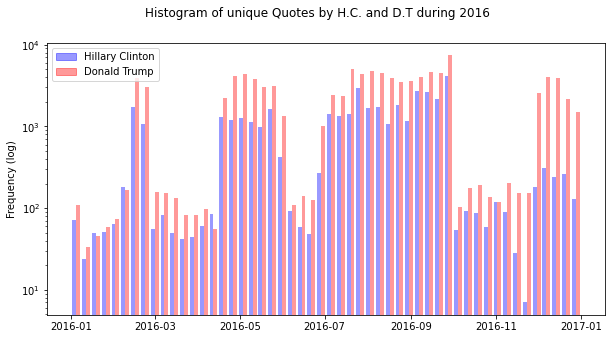

Post Filter


<Figure size 432x288 with 0 Axes>

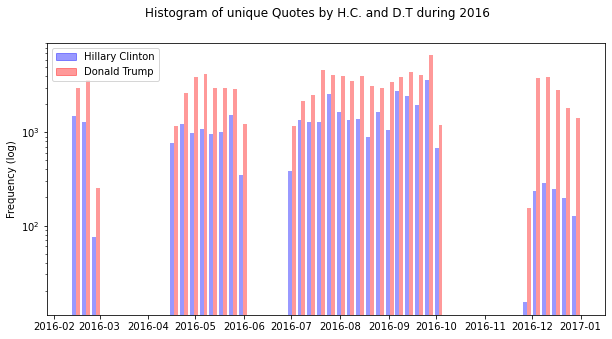

<Figure size 432x288 with 0 Axes>

In [25]:
#
# Removes any quotes which are inside the data gaps as found above.
#
DATE_CUTOFFS = [
    ('2016-02-12', '2016-02-25'),
    ('2016-04-17', '2016-06-01'),
    ('2016-06-30', '2016-10-01'),
    ('2016-11-30', '2017-01-01')
]


def remove_quotes_inside_data_gaps(df):
    df = df.copy()
    df = df[
        ((DATE_CUTOFFS[0][0] < df['date']) & (df['date'] < DATE_CUTOFFS[0][1])) |
        ((DATE_CUTOFFS[1][0] < df['date']) & (df['date'] < DATE_CUTOFFS[1][1])) |
        ((DATE_CUTOFFS[2][0] < df['date']) & (df['date'] < DATE_CUTOFFS[2][1])) |
        ((DATE_CUTOFFS[3][0] < df['date']) & (df['date'] < DATE_CUTOFFS[3][1]))

    ]

    return df


print("Pre Filter")
quotes_hist_split_rough(df_3, weighted=False, use_log=True)
print("Post Filter")
example = remove_quotes_inside_data_gaps(df_3)
quotes_hist_split_rough(example, weighted=False, use_log=True)

### Clean Data

Using our insights from the EDA we apply the different filters to "clean" our dataset, which is then ready for proper analysis.

In [26]:
df_cleaned = df_2.copy()
print("Pre-Cleaning:  {:>10,} Quotes".format(len(df_cleaned)))

# Reassign quotes to Trump
df_cleaned = assign_quotes_for_president_dt_to_dt(df_cleaned)

# Remove quotes which are of  other speakers
df_cleaned = only_keep_dt_and_hc_quotes(df_cleaned)

# Remove any quote inside  our identified data gaps.
df_cleaned = remove_quotes_inside_data_gaps(df_cleaned)

n_removed = len(df_2) - len(df_cleaned)
per_removed = n_removed / len(df_2)
print("Removed:       {:>10,} Quotes or {:.2%} of the Original Data".format(
    n_removed, per_removed))
print("Post-Cleaning: {:>10,} Quotes".format(len(df_cleaned)))

display(df_cleaned.head())

Pre-Cleaning:     144,127 Quotes
Removed:            5,618 Quotes or 3.90% of the Original Data
Post-Cleaning:    138,509 Quotes


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba
0,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,[Q6294],2016-07-11 17:26:06,1,"[[Hillary Clinton, 0.9025], [None, 0.0975]]",[http://www.breitbart.com/tech/2016/07/11/hill...,E,0.9025
1,2016-07-28-001820,a little bit personally.,Donald Trump,"[Q22686, Q27947481]",2016-07-28 10:26:34,2,"[[Donald Trump, 0.7921], [None, 0.1568], [Bria...",[http://lcsun-news.com/story/news/politics/onp...,E,0.7921
2,2016-08-27-001626,A vote for Clinton is a vote for open borders.,Donald Trump,"[Q22686, Q27947481]",2016-08-27 23:31:11,1,"[[Donald Trump, 0.8488], [None, 0.1176], [Hill...",[http://whotv.com/2016/08/27/trump-takes-stage...,E,0.8488
3,2016-05-24-003322,"Additionally, all sorts of `horrors' had been ...",Donald Trump,"[Q22686, Q27947481]",2016-05-24 08:59:38,1,"[[Donald Trump, 0.6887], [None, 0.2613], [Matt...",[http://nmpolitics.net/index/2016/05/do-the-up...,E,0.6887
4,2016-08-20-002872,AMERICA is once again at a moment of reckoning...,Hillary Clinton,[Q6294],2016-08-20 06:02:42,1,"[[Hillary Clinton, 0.9679], [None, 0.0321]]",[http://asianjournal.com/lifestyle/dnc-chronic...,E,0.9679


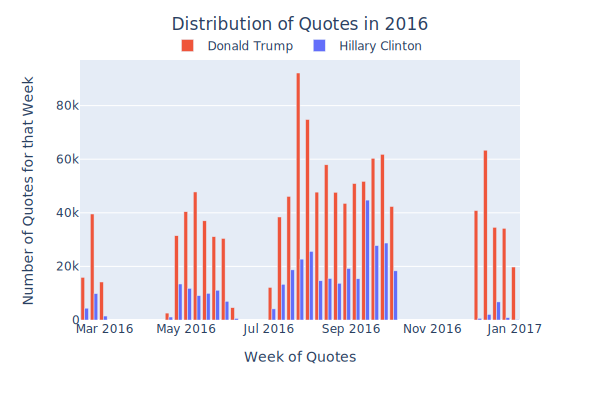

In [53]:
def quotes_hist_split(df):

    pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')

    df = df.groupby(
        by=['speaker', pd.Grouper(key='date', freq='W-MON')]
    ).sum('date').reset_index()


    fig = px.bar(
        df,
        x='date',
        y='numOccurrences',
        color='speaker',
        barmode='group',
        color_discrete_map={
            'Hillary Clinton': px.colors.qualitative.Plotly[0],
            'Donald Trump': px.colors.qualitative.Plotly[1],
        },
        width=600,
        height=400,
        hover_data={
            'speaker': True,
            'date': True,
            'numOccurrences': True
        },
    )

    # customize font and legend orientation & position
    fig.update_layout( 
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title_x=0.5,
        title_text="Distribution of Quotes in 2016",
        xaxis_title_text='Week of Quotes',
        yaxis_title_text='Number of Quotes for that Week', 
        #yaxis=dict(tickformat=".2%"),
    )

    save_and_show(fig, "quotes_date_distributiion_plot",
              save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

quotes_hist_split(df_cleaned)

In [29]:
# NOTE: This should  be removed and is just so the code doesn't break after (Dean) having resturctured the cleaning process.
df_3_2 = df_cleaned.copy()

In [30]:
df_dt = df_cleaned[df_cleaned['speaker'] == DT]
df_hc = df_cleaned[df_cleaned['speaker'] == HC]

#### Sample

In [31]:
cleaned_sample, dt_cleaned_sample, hc_cleaned_sample = get_df_samples(
    df_cleaned)

## 4. Our Focus Questions

###  Introduction & Background

#### What data  do we have?

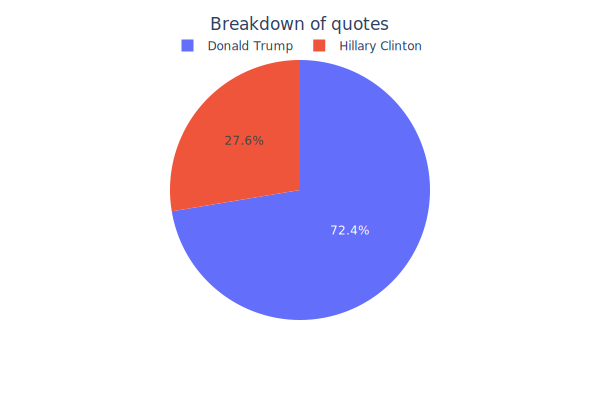

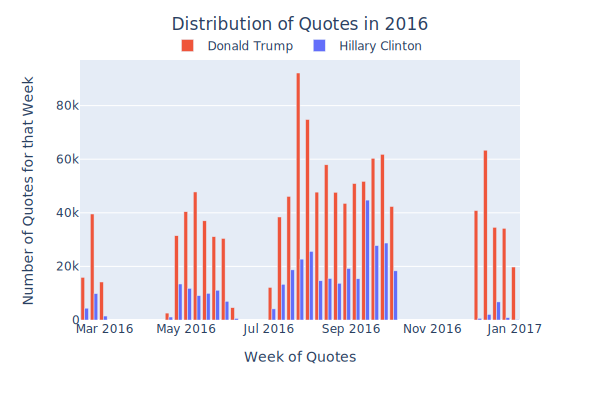

In [54]:
df_pie_unique = df_cleaned.groupby('speaker').count().reset_index()
df_pie_numOccurances = df_cleaned.groupby('speaker').sum().reset_index()

fig = px.pie(
    df_pie_unique,
    values='quotation',
    names='speaker',
    color_discrete_map={
            'Hillary Clinton': px.colors.qualitative.Plotly[0],
            'Donald Trump': px.colors.qualitative.Plotly[1],
    },
    width=600,
    height=400
)
fig.update_layout( 
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title_x=0.5,
        title_text='Breakdown of quotes'
    )

save_and_show(fig, "pie_chart_unique",
              save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

quotes_hist_split(df_cleaned)

### Q1: Media Bias

Do media outlets portray Trump and Clinton differently? Do media outlets quote the two candidates equally much? Does the bias of the news outlet correlate with the quotes they report?

Let's take two of the biggest outlets with political leaning views, CNN and Breitbart, and compare the distribution of Trump quotes with Clinton quotes, and also see how positive or negative they are.

The NLTK library will also be used for sentiment analysis later on.

In [ ]:


def flatten(_list):
    return list(itertools.chain(*_list))


sia = SentimentIntensityAnalyzer()


def valence(quote):
    return sia.polarity_scores(quote)["compound"]

In [ ]:
full_urls = flatten(df_cleaned["urls"].to_list())
stripped_urls = list({strip_url(url) for url in full_urls})
pd.DataFrame(pd.Series(stripped_urls).unique())

In [ ]:
quotes_by_outlet = dict()

for i, row in df_cleaned.iterrows():
    quote, speaker, urls = row["quotation"], row["speaker"], row["urls"]

    for url in urls:
        outlet = strip_url(url)

        v = quotes_by_outlet.get(outlet)
        if v is None:
            v = {HC: [], DT: []}

        # A quote cannot appear more than once per outlet.
        if quote not in v[speaker]:
            v[speaker].append(quote)
        quotes_by_outlet[outlet] = v

df_by_outlet = pd.DataFrame.from_dict(quotes_by_outlet, orient="index")
df_by_outlet

We load the media bias dataset. The bias is translated from survey answers ("left-center", "center", "right"...)
and the weight is based on the confidence in the bias rating (a non-linear function combining the number of votes and the agreement rate).
You can find the cleaning and transformation process in `scripts/allsides.py`.

In [ ]:
df_mb = pd.read_csv("data/allsides.csv")
df_mb

In [ ]:
mb_count = df_mb.groupby("bias").count()["total_votes"]

fig = px.bar(mb_count,
             labels={"bias": "Bias", "value": "Number of outlets"},)

fig.update_traces(
    marker_color="rgb(150,150,150)"
)

fig.update_layout(
    font_family="Rockwell",
    title="Number of outlets with given bias",
    title_x=0.5,
    width=600, height=400,
    showlegend=False,
)

fig.update_xaxes(
    tickmode='array',
    tickvals=[-2, -1, 0, 1, 2],
    ticktext=["Left", "LC", "Center", "RC", "Right"],
)

save_and_show(fig, "bias_distribution",
              save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

In [ ]:
df_mb_valence = df_by_outlet.merge(df_mb, left_index=True, right_on="url")
df_mb_valence.index = df_mb_valence["name"]
df_mb_valence.drop("name", axis=1, inplace=True)


def map_quotes(quotes): return [valence(q) for q in quotes]


df_mb_valence["hc_valence"] = df_mb_valence[HC].apply(map_quotes)
df_mb_valence["dt_valence"] = df_mb_valence[DT].apply(map_quotes)

df_mb_valence.head(5)

In [ ]:
len(df_mb_valence)

In [ ]:
df_mv_hc = df_mb_valence.copy()
df_mv_hc["valence"] = df_mv_hc["hc_valence"]
df_mv_hc = df_mv_hc.drop([HC, DT, "hc_valence", "dt_valence"], axis=1)
df_mv_hc = df_mv_hc.explode("valence")
df_mv_hc.head()

In [ ]:
df_mv_dt = df_mb_valence.copy()
df_mv_dt["valence"] = df_mv_dt["dt_valence"]
df_mv_dt = df_mv_dt.drop([HC, DT, "hc_valence", "dt_valence"], axis=1)
df_mv_dt = df_mv_dt.explode("valence")
display(df_mv_dt.head())

In [ ]:
def plot_hist2d(df, candidate):

    if candidate == DT:
        color = red
        x = 1
    elif candidate == HC:
        color = blue
        x = 0.4
    else:
        raise(f"Expected candidate to be one of [{DT}, {HC}]")

    args = {
        "x": df["bias"],
        "y": df["valence"],
        "ybins": dict(
            start=-1.1,
            end=1.1,
            size=0.2
        ),
        "z": df["weight"],
        "histfunc": "sum",
        "histnorm": "probability",
        "colorbar": dict(
            len=1.05,
            x=x,
            y=0.49,
            dtick=0.04
        ),
        "colorscale": ["white", color],
        "showscale": True,
    }
    return go.Histogram2d(args)

In [ ]:
fig = make_subplots(
    cols=2,
    shared_yaxes="columns",
    x_title='Media bias',
    y_title='Sentiment',
    horizontal_spacing=0.2,
    subplot_titles=[HC, DT])

fig.update_layout(
    font_family="Rockwell",
    legend=dict(
        title=None,
        orientation="h",
        y=1,
        yanchor="bottom",
        x=0.5,
        xanchor="center",
    ),
    title="Distribution of sentiment and media bias",
    title_x=0.5,
)

fig.update_xaxes(
    tickmode='array',
    tickvals=[-2, -1, 0, 1, 2],
    ticktext=["Left", "LC", "Center", "RC", "Right"],
    tickangle=0,
)

fig.add_trace(plot_hist2d(df_mv_hc, HC), row=1, col=1)
fig.add_trace(plot_hist2d(df_mv_dt, DT), row=1, col=2)

save_and_show(fig, "mb_valence_hist2d",
              save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

In [ ]:
def plot_hist(fig, outlet_name):

    if outlet_name in df_mb_valence.index:
        outlet = df_mb_valence.loc[outlet_name]
        bias = outlet.bias
    else:
        raise(ValueError(f"{outlet_name} is not a valid outlet name"))

    nbins = 5

    args = dict(
        histnorm="probability",
        showlegend=bool(bias == -2),
        ybins=dict(
            start=-1.1,
            end=1.1,
            size=0.2,
        ),
        opacity=0.7
    )

    args_hc = dict(
        **args,
        name=HC,
        marker=dict(color=blue),
        y=outlet["hc_valence"],
    )

    args_dt = dict(
        **args,
        name=DT,
        marker=dict(color=red),
        y=outlet["dt_valence"],
    )

    fig.add_trace(go.Histogram(args_hc), col=bias+3, row=1)
    fig.add_trace(go.Histogram(args_dt), col=bias+3, row=1)

    title_text = f"{outlet_name.split(' (')[0]}"
    fig.update_xaxes(title_text=title_text, col=bias+3, row=1)


outlet_names = ["CNN (Online News)", "Washington Post",
                "The Hill", "Newsmax (News)", "Breitbart News"]

fig = make_subplots(
    cols=5,
    shared_yaxes=True,
    x_title='Probability of occurrence',
    y_title='Sentiment',
)

fig.update_xaxes(
    tickmode='array',
    tickvals=[0.2, 0.4],
    ticktext=["", ""],
)

fig.update_yaxes(
    tickmode='array',
    tickvals=[-1, -0.5, 0, 0.5, 1],
)

fig.update_layout(
    barmode='overlay',
    font_family="Rockwell",
    legend=dict(
        title="Speaker",
        orientation="h",
        y=1,
        yanchor="bottom",
        x=0.5,
        xanchor="center",
    ),
    title="Distribution of sentiment for certain media outlets",
    title_x=0.5,
)

for name in outlet_names:
    plot_hist(fig, name)

save_and_show(fig, "mb_valence_hist_samples",
              save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

### Q2: Political Topics

We want to track the different political topics that the candidates focused on according to the content of their quotes. From this we aim to learn the importance of the topics in a absolut relative context but also in regards to when a certain topic might have been very present and then. disappeared for some time. We furthermore want to see if there might be a candidate which sparked a topic or at least started talking/being quoted about it first. Two approaches are used:

1. Extracting and finding topics using Machine Leanring (LDA).
2. Specifying topics by buiding a REGEX. Done  both for topics suggested by the LDA model as well as for a known topic to extracting matching quotes.


#### LDA Topic Extraction

In [33]:
#
# If set to True the entire topic extraction pipeline will be executed which takes a lot of time.
# If set to False it is possible to execute parts of the pipeline (see sections below).
#
TOPICS_FROM_SCRATCH = False

We get a quick look of the textual data we have available.

In [34]:
#
# We create one blob of text, consisting of all quotes in the dataset.
#
merged_quotes = ' '.join(df_cleaned['quotation'].values)
#
print("Quotes in Dataset:          {:>10,}".format(len(df_cleaned)))
print("Characters in Text:         {:>10,}".format(len(merged_quotes)))
print("Spacy maximum:              {:>10,}".format(1_000_000))
print()
print("Clinton Quotes in Dataset:  {:>10,}".format(
    len(df_cleaned[df_cleaned['speaker'] == 'Hillary Clinton'])))
print("Trump Quotes in Dataset:    {:>10,}".format(
    len(df_cleaned[df_cleaned['speaker'] == 'Donald Trump'])))

Quotes in Dataset:             138,509
Characters in Text:         15,692,651
Spacy maximum:               1,000,000

Clinton Quotes in Dataset:      38,263
Trump Quotes in Dataset:       100,246


Since the amount of data is too big to run on my computer we need to break it down.

##### Prepare Data

In [35]:
daily_quotes_aggregate = df_cleaned.groupby([df_cleaned['date'].dt.date]).apply(
    lambda group: group['quotation'].values).to_frame(name='quotes')  # , columns=['date', 'quotes'])

print("{:} days with Quotes.".format(len(daily_quotes_aggregate)))
display(daily_quotes_aggregate)

183 days with Quotes.


,quotes
date,
2016-02-12,[I want us to be partners with state and local...
2016-02-13,[was defined by his reverence for the Constitu...
2016-02-14,[I have one the world's most complicated tax r...
2016-02-15,"[They want to take those planes, and they want..."
2016-02-16,[The work that each and every one of your orga...
...,...
2016-12-27,[One of the things you should do in terms of s...
2016-12-28,[President Obama said he thinks he would have ...
2016-12-29,"[would kill a lot of Syrians., And, then, to c..."


##### Defining our NLP Model

We use this model to process the each quote in preparation for the topic extracion model (LDA).

In [36]:
nlp = spacy.load('en_core_web_sm')  # Load Spacy English


def lemmatizer(doc):
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)


def remove_stopwords(doc):
    # Remove stopwords, punctuation and words with less than 3 characters.
    tokens = [token for token in doc if not token.is_stop]
    tokens = [token for token in tokens if not token.is_punct]
    doc = [token.text for token in tokens if len(token) > 2]
    return doc


nlp.add_pipe(lemmatizer, name='lemmatizer', after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [37]:
NLP_PROCESS_QUOTES = False or TOPICS_FROM_SCRATCH  # Should take < 15 minutes.

NLP_MODEL_PATH = 'topics/nlp-model'
DOCUMENTS_FILE = 'topics/documents.pickle'

if NLP_PROCESS_QUOTES:

    print("Processing quotes using Spacy NLP..")

    daily_quotes = daily_quotes_aggregate['quotes'].values

    documents = []

    for day_quotes in tqdm(daily_quotes):
        merged_quotes = ''.join(day_quotes)

        documents.append(nlp(merged_quotes))

    # Write to disk
    nlp.to_disk(NLP_MODEL_PATH)
    docs_file = open(DOCUMENTS_FILE, 'wb')
    pickle.dump(documents, docs_file)

else:
    print("Reading from file...")
    nlp = nlp.from_disk(NLP_MODEL_PATH)

    docs_file = open(DOCUMENTS_FILE, "rb")
    documents = pickle.load(docs_file)

print("\nSample of 1 document:\n")
print(documents[0][0:40])

Reading from file...

Sample of 1 document:

['want', 'partner', 'state', 'local', 'school', 'board', 'try', 'sure', 'school', 'prepared', 'century', 'child', 'attend', 'chance', 'good', 'possible', 'education', 'end', 'school', 'prison', 'pipeline', 'tackle', 'disparity', 'health', 'nutrition', 'fight', 'environmental', 'justice', 'include', 'clean', 'water', 'want', 'follow', 'leadership', 'know', 'today', 'Senator', 'Sanders', 'President', 'Obama']


##### Build Corpus and ID2words for LDA

In [38]:
def build_word_dictionary(documents, max_freq=0.5, min_wordcount=5):
    words = corpora.Dictionary(documents)
    print(
        "Words in Corpus:     {:>8,}     |  After Spacy NLP".format(len(words)))

    words.filter_extremes(no_below=min_wordcount, no_above=max_freq)
    print(
        "Words in Corpus:     {:>8,}     |  After removing words with too low/high frequency)\n".format(len(words)))

    return words


def build_corpus(words, documents):

    # Turns each document into a bag of words.
    corpus = [words.doc2bow(document) for document in documents]
    print("Documents in Corpus: {:>8}     |  1 document per day in our data range\n".format(
        len(corpus)))

    return corpus

In [39]:
words = build_word_dictionary(documents)
corpus = build_corpus(words, documents)

Words in Corpus:       58,877     |  After Spacy NLP
Words in Corpus:        7,454     |  After removing words with too low/high frequency)

Documents in Corpus:      183     |  1 document per day in our data range



##### Train LDA modelto extract topics

In [40]:
#
# Read model from Disk or train from scratch.
#
NEW_MODEL = TOPICS_FROM_SCRATCH

N_TOPICS = 50  # Number of topics to extract

GENSIM_MODEL_FILE_NAME = 'topics/gensim-model/lda-model.gensim'

if NEW_MODEL:

    print("Training new model...")
    model = LdaMulticore(
        corpus=corpus,
        id2word=words,
        num_topics=N_TOPICS,
        workers=6,
        passes=50,
        random_state=SEED
    )
    model.save(GENSIM_MODEL_FILE_NAME)
    print("Done training new model. Saved to file...")

else:

    print("Reading from file...")
    model = LdaMulticore.load(GENSIM_MODEL_FILE_NAME)

Reading from file...


In [41]:
print("\nShow Top 5 words for each extracted topics:")
display(model.show_topics(num_topics=-1, num_words=5))


Show Top 5 words for each extracted topics:


[(0,
  '0.022*"FBI" + 0.015*"circuit" + 0.015*"truthful" + 0.014*"tape" + 0.011*"Comey"'),
 (1,
  '0.037*"star" + 0.020*"Hussein" + 0.017*"Saddam" + 0.017*"David" + 0.015*"Star"'),
 (2,
  '0.000*"Cruz" + 0.000*"delegate" + 0.000*"inner" + 0.000*"deplorable" + 0.000*"classified"'),
 (3,
  '0.073*"founder" + 0.011*"valuable" + 0.011*"award" + 0.011*"crooked" + 0.010*"found"'),
 (4,
  '0.000*"Cruz" + 0.000*"shy" + 0.000*"temperament" + 0.000*"Ted" + 0.000*"Apple"'),
 (5,
  '0.002*"vice" + 0.002*"Muslim" + 0.002*"count" + 0.002*"Kaine" + 0.002*"mail"'),
 (6,
  '0.015*"Mike" + 0.013*"Pence" + 0.007*"France" + 0.007*"final" + 0.006*"Tim"'),
 (7,
  '0.021*"computer" + 0.013*"January" + 0.011*"greatly" + 0.009*"complicate" + 0.008*"Christmas"'),
 (8,
  '0.021*"vicious" + 0.015*"violent" + 0.013*"scream" + 0.013*"zone" + 0.011*"steal"'),
 (9,
  '0.016*"charity" + 0.008*"rattle" + 0.008*"bounce" + 0.008*"rating" + 0.007*"friendly"'),
 (10,
  '0.019*"poverty" + 0.018*"unemployed" + 0.017*"youth" 

Based on the words of the topics cluster function we assign each of the LDA topics to a topic based on searching google for the keyqords or topics we remember ourselves. Some of these topics are very obvious and remebered by many and others are surprisingly niche and not remembered by  most and maybe never heard of by some.

In [42]:
id_to_topic_name_list = [
    ([0], 'The FBI and Comey'),
    ([1], 'Trump  Praising Sadam Hussein'),
    ([2, 4, 17, 18, 22, 28, 31, 33, 34, 41, 44, 49], 'Ted Cruz'),
    ([3], 'Crooked Hillary'),
    ([5], 'Vice Candidate Kaine (Clinton) and Muslims'),
    ([6, 30], 'Vice Candidate Pence (Trump)'),
    ([8], 'Stolen Election?'),
    ([10], 'Poverty and Unemployment'),
    ([11], 'House Speaker Paul Ryan'),
    ([12], 'Boeing Order: Air Force One (Post Election)'),
    ([14], 'Israel & Palestine'),
    ([15, 48], 'Speech by Muslim Parents at the DNC'),
    ([20, 32], 'Clinton’s: “Deplorables, Sexists and Xenophobes”'),
    ([23, 40], '(Illegal) Immigration'),
    ([24], 'Clinton Email Scandal'),
    ([37], 'Education'),
    ([39, 45], 'Islam & Muslims'),
    ([42], 'Chris Christies and his Weight'),
    ([43], 'Ted Cruz and Harvey Lee Oswald Conspiracy'),
    ([46], 'Justice Scalia'),
    ([47], 'Amazon'),
    ([7, 9, 13, 16, 19, 21, 25, 26, 27, 29, 35, 36, 38], 'Other')
]

In [43]:
# visualizable_data = pyLDAvis.gensim_models.prepare(model, corpus, words, sort_topics=False)
#
# pyLDAvis.display(visualizable_data)

##### Assign each quote to a topic

In [44]:
#
# If set to TRUE we will re-assign all quotes based on the latest model.
#
RE_ASSIGN = TOPICS_FROM_SCRATCH  # takes alot of time (>15 minutes).

#
# Extracting the most likely topic out of a quote (or any text).
#


def assign_topic_id(quote):

    document = nlp(quote)
    document_bow = words.doc2bow(document)

    topics = model.get_document_topics(document_bow)
    topics = sorted(topics, key=lambda topic: topic[1], reverse=True)

    top_topic = topics[0][0]

    return top_topic


#
# Get dataframe with topic id assigned to each quote/row
# (Recomputed or Read from File)
#
if RE_ASSIGN:
    print("Re-assigning each quote/row based  on current model. (will take a while!)")
    df_cleaned['topic_id'] = df_cleaned['quotation'].apply(
        lambda quote: assign_topic_id(quote))

    df_cleaned_with_topics = df_cleaned.copy()

    #  Write to disk
    df_cleaned_with_topics.to_csv('data/df_cleaned_with_topics.csv')
else:
    print("Reading from file...")
    df_cleaned_with_topics = pd.read_csv('data/df_cleaned_with_topics.csv')

Reading from file...


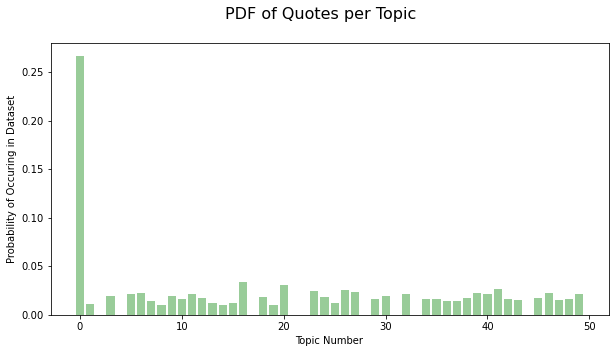

<Figure size 432x288 with 0 Axes>

In [45]:

fig, ax = plt.subplots(figsize=(10, 5))

fig.suptitle("PDF of Quotes per Topic", fontsize=16)

hist = np.bincount(df_cleaned_with_topics['topic_id']) / len(df_cleaned_with_topics)

ax.bar(range(50), hist, color='green', alpha=0.4)
ax.set_xlabel("Topic Number")
ax.set_ylabel("Probability of Occuring in Dataset")

plt.show()
plt.clf()

After seing this chart we investigated further since the assignment seemed suspicious. Let us see a sample of quotes assigned to topic with ID 0.

In [46]:
print("Function of topic 0 \n{:}".format(model.print_topic(0)))

for idx, sample_row in df_cleaned_with_topics[df_cleaned_with_topics['topic_id'] == 0].sample(3).iterrows():
    
    print("–––––")
    sample_quote = sample_row['quotation']
    print("Quote: '{}'".format(sample_quote))
    
    # Re-assign
    document = nlp(sample_quote)
    document_bow = words.doc2bow(document)

    topics = model.get_document_topics(document_bow)
    
    topics = sorted(topics, key= lambda topic : topic[1], reverse=True)
    top_topic_id = topics[0][0]
    
    print("Top 5 suggested topics: \n{}".format(topics[0:5]))


Function of topic 0 
0.022*"FBI" + 0.015*"circuit" + 0.015*"truthful" + 0.014*"tape" + 0.011*"Comey" + 0.010*"Paul" + 0.010*"consistent" + 0.010*"classified" + 0.009*"publicly" + 0.008*"disagree"
–––––
Quote: 'I don't think so. I want to be myself,'
Top 5 suggested topics: 
[(0, 0.02), (1, 0.02), (2, 0.02), (3, 0.02), (4, 0.02)]
–––––
Quote: 'First of all, they did get paid a lot but taking advantage of the laws of the nation.... Now, if you want to change the laws, you've been there a long time, change the laws. But I take advantage of the laws of the nation because I'm running a company.'
Top 5 suggested topics: 
[(0, 0.02), (1, 0.02), (2, 0.02), (3, 0.02), (4, 0.02)]
–––––
Quote: 'market forces are something I don't want to get involved with. The market force is a beautiful force.'
Top 5 suggested topics: 
[(0, 0.02), (1, 0.02), (2, 0.02), (3, 0.02), (4, 0.02)]


After looking at to different  assignments as showed in the example above, we realised, that most quotes are simply too short in text to  actually match with a topic. After all we remove many words in the NLP step and the remaining words are few so the likelihood of a word matching with a word in one of the LDA cluster functions is low by the  nature of the data type. The conclusion we draw from this is to use LDA to find interesting topics, which we actually did, but not  to assign quotes to a topic. For this we use th next step.

#### Topic Assignment

Using the topics identified by LDA as well as some topics that were/are prominent from that election year we select a few to dig deeper.

In [47]:
regex_topics = [
    ('Ted  Cruz', '( ted )|( cruz )'),
    ('Obamacare', '(obama care)|obamaca\\w{1,5}|(Affordable Care Act)'),
    ('Healthcare', '(health care)|healthcare'),
    ('Guns & Shootings', 'gun|guns|shot|shooting|shoot'),
    ('FBI Probe of 2016', 'comey|mueller|fbi'),
    ('Russia', 'russia|putin|kremlin'),
    ('Khan Speech at the DNC', 'khan|dnc'),
    ('Ted Cruz and JFK Conspiracy', '(?=.*cruz\\b)(?=.*harvey\\b)'),
    ('Crooked Hillary', '(?=.*hillary\\b)(?=.*crooked\\b)(?=.*clinton\\b)'),
    ('Trump praises Saddam Hussein', 'saddam|hussein'),
    ('Abortion', 'abortion|"pro life"|"pro choice"')
];

In [48]:
table_str =  "|Topic Title| # Matching Quotes |\n"
table_str += "|    ---    |         ---       |\n"

#
# Compute total number of quotes matching the topics (per topic)
#
for name, regex in regex_topics:
    df = df_cleaned[
            df_cleaned['quotation'].str.contains(
            regex,
            regex = True,
            flags=re.IGNORECASE
            )
        ]
    table_str += "|{}|{:>5}|\n".format(name, len(df))

/var/folders/8j/f1dfpg5j4fj0bmplpjmwq73c0000gn/T/ipykernel_8879/3857137698.py:9: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [49]:
print("Markdown Table Format:")
print(table_str)
print()
display(Markdown(table_str))

Markdown Table Format:
|Topic Title| # Matching Quotes |
|    ---    |         ---       |
|Ted  Cruz|  719|
|Obamacare|  290|
|Healthcare|  438|
|Guns & Shootings| 1928|
|FBI Probe of 2016|  376|
|Russia| 2105|
|Khan Speech at the DNC|  342|
|Ted Cruz and JFK Conspiracy|   16|
|Crooked Hillary|  301|
|Trump praises Saddam Hussein|  147|
|Abortion|  231|




|Topic Title| # Matching Quotes |
|    ---    |         ---       |
|Ted  Cruz|  719|
|Obamacare|  290|
|Healthcare|  438|
|Guns & Shootings| 1928|
|FBI Probe of 2016|  376|
|Russia| 2105|
|Khan Speech at the DNC|  342|
|Ted Cruz and JFK Conspiracy|   16|
|Crooked Hillary|  301|
|Trump praises Saddam Hussein|  147|
|Abortion|  231|


In [50]:
df_daily_speaker_quotes = df_cleaned.copy()
df_daily_speaker_quotes = df_daily_speaker_quotes.sort_values('date')


pd.to_datetime(df_daily_speaker_quotes['date']) - pd.to_timedelta(7, unit='d')

df_daily_speaker_quotes = df_daily_speaker_quotes.groupby(
    by=['speaker', pd.Grouper(key='date', freq='W-MON')]
).sum('date').reset_index()

df_daily_speaker_quotes = df_daily_speaker_quotes.groupby(by=['speaker', 'date']).sum('numOccurrences').reset_index()

def normalis_quote_count_by_date(row):
    total_quotes_that_day =  df_daily_speaker_quotes[
        (df_daily_speaker_quotes['speaker'] == row['speaker']) &
        (df_daily_speaker_quotes['date'] == row['date'])
    ]['numOccurrences'].tolist()[0]
        
    return row['numOccurrences'] / total_quotes_that_day

/var/folders/8j/f1dfpg5j4fj0bmplpjmwq73c0000gn/T/ipykernel_8879/1870931425.py:3: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



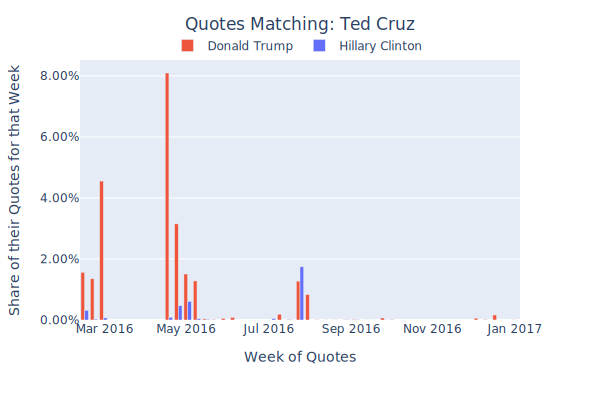

/var/folders/8j/f1dfpg5j4fj0bmplpjmwq73c0000gn/T/ipykernel_8879/1870931425.py:3: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



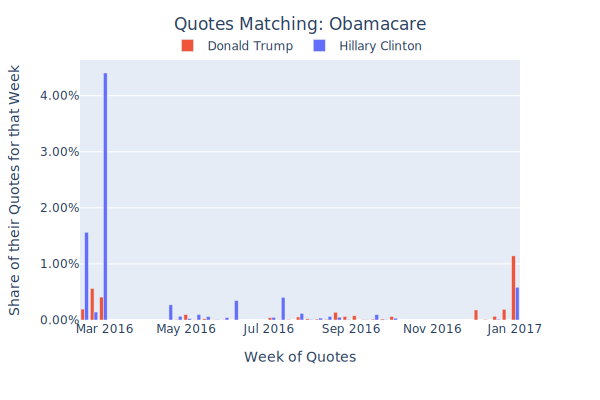

/var/folders/8j/f1dfpg5j4fj0bmplpjmwq73c0000gn/T/ipykernel_8879/1870931425.py:3: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



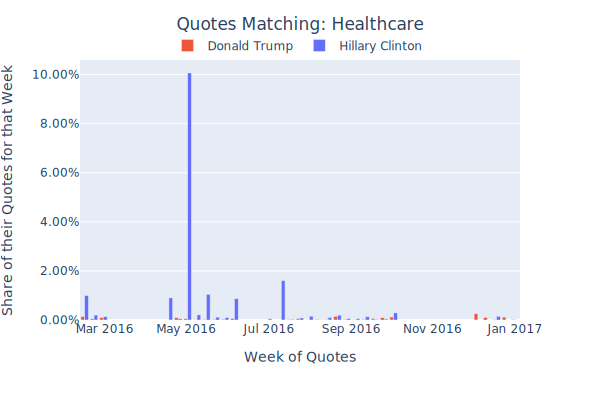

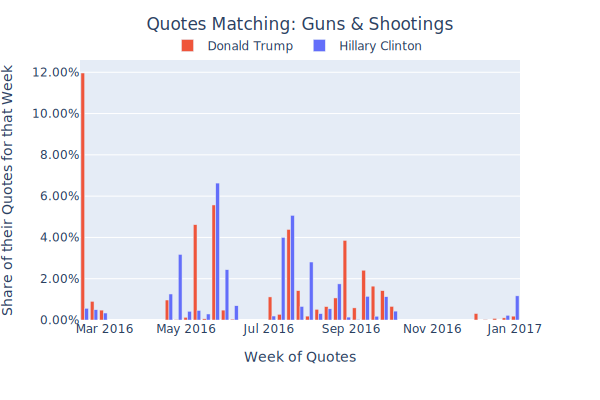

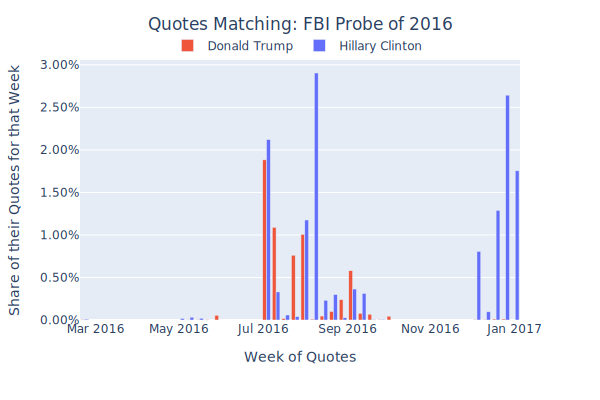

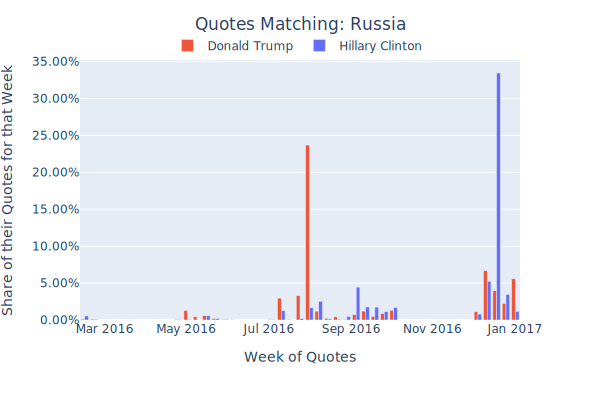

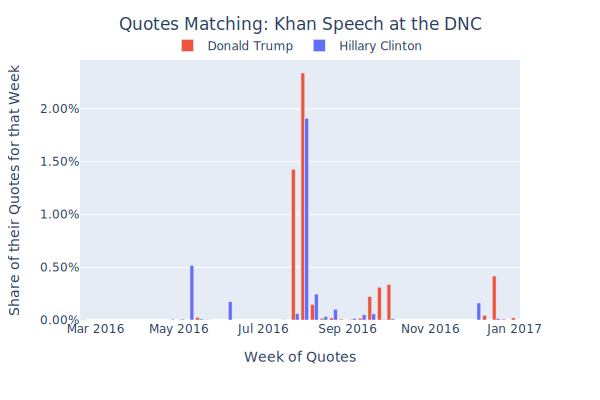

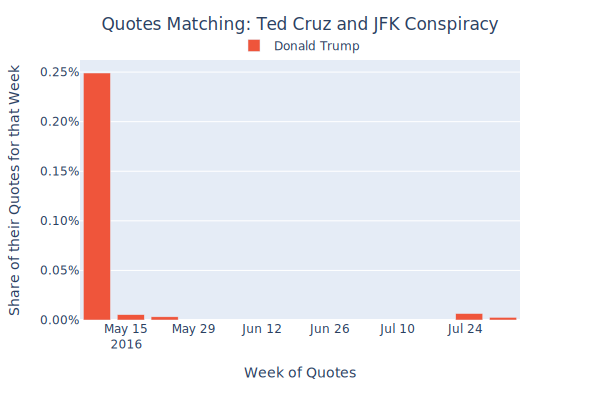

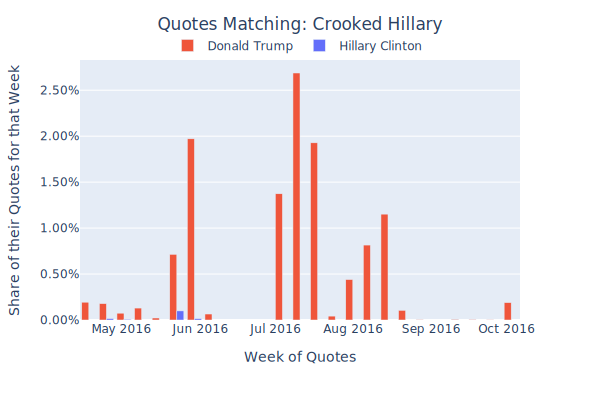

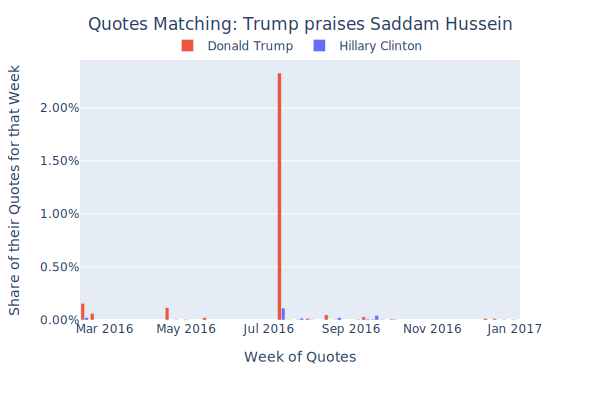

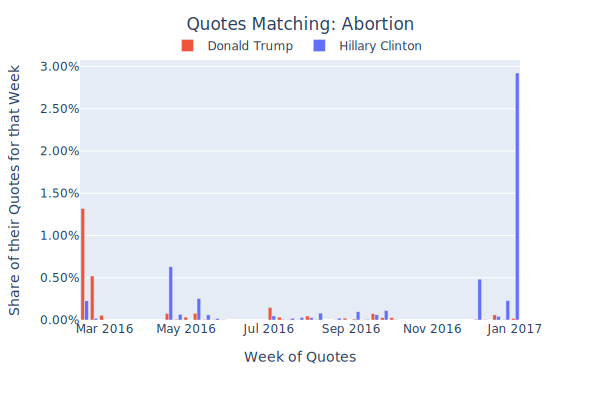

In [52]:
for topic_name, regex in regex_topics:
    df = df_cleaned[
        df_cleaned['quotation'].str.contains(
            regex,
            regex = True,
            flags=re.IGNORECASE
        )
    ]
    pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')

    df = df.groupby(
        by=['speaker', pd.Grouper(key='date', freq='W-MON')]
    ).sum('date').reset_index()

    df['shareOfDay'] = df.apply(lambda row: normalis_quote_count_by_date(row), axis=1)

    fig = px.bar(
        df,
        x='date',
        y='shareOfDay',
        color='speaker',
        barmode='group',
        color_discrete_map={
            'Hillary Clinton': px.colors.qualitative.Plotly[0],
            'Donald Trump': px.colors.qualitative.Plotly[1],
        },
        width=600,
        height=400,
        hover_data={
            'speaker': True,
            'date': True,
            'shareOfDay': False,
            'numOccurrences': True
        },
    )

    # customize font and legend orientation & position
    fig.update_layout( 
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title_x=0.5,
        title_text='Quotes Matching: ' + topic_name,
        xaxis_title_text='Week of Quotes',
        yaxis_title_text='Share of their Quotes for that Week', 
        yaxis=dict(tickformat=".2%"),
        #bargroupgap=0.05, # gap between bars of the same location coordinates
    )

    snake_case_topic_name = re.sub(" ", '_', topic_name).lower()

    save_and_show(fig, snake_case_topic_name,
              save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

### Q3: Language

#### a) Intellectuality of Language

Idea 1: Count the syllables in each candidate's consolidated quotes and compare distributions

In [ ]:
dt_quotes = df_dt["quotation"]
hc_quotes = df_hc["quotation"]
dt_text = ' '.join(dt_quotes)
hc_text = ' '.join(hc_quotes)

In [ ]:
def syl(quotes_text):
    df = pd.DataFrame()
    df["word"] = quotes_text.split()
    df["syllables"] = df["word"].apply(syllables.estimate)
    return df


dt_syl = syl(dt_text)
hc_syl = syl(hc_text)

In [ ]:
def syllables_hist(dt_syl, hc_syl):

    args_dt = dict(
        name=DT,
        marker={"color": red},
        x=dt_syl,
        histnorm="probability density",
    )

    args_hc = dict(
        name=HC,
        marker={"color": blue},
        x=hc_syl,
        histnorm="probability density",
    )

    fig = go.Figure()

    fig.add_trace(go.Histogram(args_dt))
    fig.add_trace(go.Histogram(args_hc))

    fig.update_xaxes(
        range=[0.5, 6.5]
    )

    fig.update_layout(
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        font=dict(size=16),
        title="Histogram of number of syllables",
        xaxis_title="Number of syllables in a word",
        yaxis_title="Probability of occuring",
        legend_title="Speaker",
        title_x=0.5,
        width=750,
        height=400,
    )

    save_and_show(fig, "syllables", save_to_disk=FIG_SAVE_TO_DISK,
                  show_mode=SHOW_MODE)


syllables_hist(dt_syl["syllables"], hc_syl["syllables"])

Idea 2: Look at the CEFR language level. We can measure the language level for all words in each candidate's consolidated quotes and compare the distributions.

In [ ]:
cefr_data = pd.read_csv("data/cefr.csv", index_col="word")

cefr_level_map = {
    "NA": 0,
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6,
}

fig = go.Figure()

fig.add_trace(go.Histogram(dict(
    histnorm="probability density",
    xbins=dict(
        start=0,
        end=6,
        size=1,
    ),
    x=cefr_data["level"],
)))


fig.update_layout(
    font=dict(
        size=16,
    ),
    font_family="Rockwell",
    legend=dict(
        title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    ),
    title="Histogram of English level of words in the CEFR dataset",
    xaxis_title="English level",
    yaxis_title="Probability of occuring",
    legend_title="Speaker",
    title_x=0.5,
    width=750,
    height=400,
)

fig.update_xaxes(
    ticktext=list(cefr_level_map.keys()),
    tickvals=list([i + 0.5 for i in range(0, 6)])
)

save_and_show(fig, "cefr", save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

In [ ]:
def lemmatize(df_quote):
    return [w for quote in sp.pipe(df_quote, n_process=8, batch_size=1000) for w in quote]

In [ ]:
s = {
    "dt": lemmatize(dt_quotes),
    "hc": lemmatize(hc_quotes),
}

In [ ]:
def take(word):
    # Take out punctuation, pronouns, proper nouns, strings containing a digit, ...
    return word.pos_ in ["NOUN", "ADJ", "VERB", "INTJ", "ADV"]\
        and word.text not in ["$", "'d", "'s", "`", "-"]


def df_level(candidate):
    df = pd.DataFrame()

    df["word"] = [w.lemma_ for w in s[candidate] if take(w)]

    def level(
        w): return cefr_data.loc[w].loc["level"] if w in cefr_data.index else 0
    df["level"] = df["word"].apply(level)

    return df


dt_level = df_level("dt")
hc_level = df_level("hc")

In [ ]:
def most_common_words(df_level):
    most_common_words = pd.DataFrame()
    for k, v in cefr_level_map.items():
        df = df_level[(df_level["level"] >= v) & (df_level["level"] < v + 1)]
        most_common_words[k] = df.groupby("word").count().sort_values(
            "level", ascending=False).head(5).index

    return most_common_words


print("Trump most common words:")
display(most_common_words(dt_level))
print("Clinton most common words:")
display(most_common_words(hc_level))

In [ ]:
def cefr_level_hist(dt_level, hc_level):

    args = dict(
        histnorm="probability density",
        xbins=dict(
            start=0,
            end=6,
            size=1,
        ),
    )

    args_dt = dict(
        **args,
        x=dt_level,
        name=DT,
        marker=dict(color=red),
    )

    args_hc = dict(
        **args,
        x=hc_level,
        name=HC,
        marker=dict(color=blue),
    )

    fig = go.Figure()

    fig.add_trace(go.Histogram(args_dt))
    fig.add_trace(go.Histogram(args_hc))

    fig.update_layout(
        font=dict(
            size=16,
        ),
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title="Histogram of English level of words",
        xaxis_title="English level",
        yaxis_title="Probability of occuring",
        legend_title="Speaker",
        title_x=0.5,
        width=750,
        height=400,
    )

    fig.update_xaxes(
        ticktext=list(cefr_level_map.keys()),
        tickvals=list([i + 0.5 for i in range(0, 6)])
    )

    save_and_show(fig, "cefr_candidates",
                  save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)


cefr_level_hist(dt_level["level"], hc_level["level"])

There seems to be little difference in terms of language levels. Just as our CEFR data has a majority of B2 words, most of the words used by our candidates are B2 words.

#### b) Sentiment Analysis

In [ ]:
df_cleaned.groupby(['speaker']).count().sort_values(
    'quotation', ascending=False)['quotation']

##### Using NLTK’s Pre-Trained Sentiment Analyzer
We use NLTK VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tools

In [ ]:
# Split dataset into Trump and Clinton datasets
hc_cleaned = df_cleaned[df_cleaned['speaker'] == 'Hillary Clinton']
dt_cleaned = df_cleaned[df_cleaned['speaker'] == 'Donald Trump']

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
trump_polarity_scores = dt_cleaned['quotation'].apply(sia.polarity_scores)
dt_cleaned['polarityScore'] = [
    score.get('compound') for score in trump_polarity_scores]

clinton_polarity_scores = hc_cleaned['quotation'].apply(sia.polarity_scores)
hc_cleaned['polarityScore'] = [
    score.get('compound') for score in clinton_polarity_scores]

In [ ]:
def print_topk_quotes(df, sentiment, k):
    if (sentiment == "positive"):
        print("Top {} {} quotes:".format(k, sentiment))
        [print("\n[+]", quote) for quote in df.sort_values('polarityScore',
                                                           ascending=False)['quotation'].head(k).tolist()]
    else:
        print("Top {} {} quotes:".format(k, sentiment))
        [print("\n[-]", quote) for quote in df.sort_values('polarityScore',
                                                           ascending=True)['quotation'].head(k).tolist()]

##### Donald Trump's 3 most positive and negative quotes

In [ ]:
print_topk_quotes(dt_cleaned, "positive", 3)
print("\n---\n")
print_topk_quotes(dt_cleaned, "negative", 3)

##### Hillary Clinton's 3 most positive and negative quotes

In [ ]:
print_topk_quotes(hc_cleaned, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_cleaned, "negative", 3)

In [ ]:
trump_df_pos = dt_cleaned[dt_cleaned['polarityScore'] >= 0]
trump_df_neg = dt_cleaned[dt_cleaned['polarityScore'] < 0]

plt.scatter(x=trump_df_pos['date'], y=trump_df_pos['polarityScore'],
            color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_df_neg['date'], y=trump_df_neg['polarityScore'],
            color='r', alpha=0.3, label="negative")

plt.title("Trump's quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

In [ ]:
clinton_df_pos = hc_cleaned[hc_cleaned['polarityScore'] >= 0]
clinton_df_neg = hc_cleaned[hc_cleaned['polarityScore'] < 0]

plt.scatter(x=clinton_df_pos['date'], y=clinton_df_pos['polarityScore'],
            color='g', alpha=0.3, label="positive")
plt.scatter(x=clinton_df_neg['date'], y=clinton_df_neg['polarityScore'],
            color='r', alpha=0.3, label="negative")

plt.title("Clinton's quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

##### Distribution of Hillary Clinton and Donald Trumps compound sentiment

In [ ]:
# calculate totals
dt_tot_quotes_count = len(dt_cleaned)
dt_pos_quotes_count = sum(dt_cleaned['polarityScore'] >= 0.05)
dt_neg_quotes_count = sum(dt_cleaned['polarityScore'] <= -0.05)
dt_neu_quotes_count = sum(np.abs(dt_cleaned['polarityScore']) < 0.05)

hc_tot_quotes_count = len(hc_cleaned)
hc_pos_quotes_count = sum(hc_cleaned['polarityScore'] >= 0.05)
hc_neg_quotes_count = sum(hc_cleaned['polarityScore'] <= -0.05)
hc_neu_quotes_count = sum(np.abs(hc_cleaned['polarityScore']) < 0.05)

# summary
print()
print('                                     Hilary Clinton     |      Donald Trump      ')
print('                                ------------------------|------------------------')
print('Total number quotes in sample:        {:>4} ({:.1%})     |      {:>4} ({:.1%})'.format(hc_tot_quotes_count, hc_tot_quotes_count/hc_tot_quotes_count,
                                                                                              dt_tot_quotes_count, dt_tot_quotes_count/dt_tot_quotes_count))
print('Number of negative quotes:            {:>4} ({:.1%})      |      {:>4} ({:.1%})'.format(hc_neg_quotes_count, hc_neg_quotes_count/hc_tot_quotes_count,
                                                                                               dt_neg_quotes_count, dt_neg_quotes_count/dt_tot_quotes_count))
print('Number of neutral quotes:             {:>4} ({:.1%})      |      {:>4} ({:.1%})'.format(hc_neu_quotes_count, hc_neu_quotes_count/hc_tot_quotes_count,
                                                                                               dt_neu_quotes_count, dt_neu_quotes_count/dt_tot_quotes_count))
print('Number of positive quotes:            {:>4} ({:.1%})      |      {:>4} ({:.1%})'.format(hc_pos_quotes_count, hc_pos_quotes_count/hc_tot_quotes_count,
                                                                                               dt_pos_quotes_count, dt_pos_quotes_count/dt_tot_quotes_count))

print("\n(Positive score > 0.05, Negative score < -0.05, Neutral score: -0.05 < score < 0.05)")

#### Sentiment analysis by topic

In [ ]:
def filter_n_concatenate_dfs(hc_sample, dt_sample, topic_keywords):
    hc_filtered = hc_sample[hc_sample['quotation'].str.contains(
        topic_keywords, case=False)]
    dt_filtered = dt_sample[dt_sample['quotation'].str.contains(
        topic_keywords, case=False)]

    hc_dt_filtered = pd.DataFrame(dict(
        candidate=np.concatenate((["Hillary Clinton"]*len(hc_filtered),
                                  ["Donald Trump"]*len(dt_filtered))),
        polarityScore=np.concatenate((hc_filtered['polarityScore'],
                                      dt_filtered['polarityScore'])),
        quotation=np.concatenate((hc_filtered['quotation'],
                                  dt_filtered['quotation']))
    ))
    hc_filtered = hc_dt_filtered[hc_dt_filtered['candidate']
                                 == "Hillary Clinton"]
    dt_filtered = hc_dt_filtered[hc_dt_filtered['candidate'] == "Donald Trump"]
    return hc_dt_filtered, hc_filtered, dt_filtered

In [ ]:
def sentimentHistogram(hc_sample, dt_sample, topic_keywords):
    hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
        hc_sample, dt_sample, topic_keywords)

    # plot with plotly
    fig = px.histogram(hc_dt_filtered, x="polarityScore", color="candidate", histnorm='probability',
                       barmode="overlay", nbins=40, marginal="box",
                       width=600, height=400,
                       log_y=True
                       )

    # customize font and legend orientation & position
    fig.update_layout(
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title_text='Sentiment distribution <br><sup>topic keywords = {'+topic_keywords+'}</sup>', title_x=0.5, title_y=0.965,
        xaxis_title_text='Sentiment (polarity compound score)',
        yaxis_title_text='Number of quotes (log scale)',
        # bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.05,  # gap between bars of the same location coordinates
    )
    fig.update_xaxes(range=[-1, 1])

    save_and_show(fig, "sentiment_hist_" +
                  topic_keywords[:5], save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

In [ ]:
def quotesCountPerSpeaker(hc_sample, dt_sample, topic_keywords):
    hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
        hc_sample, dt_sample, topic_keywords)

    quote_counts = hc_dt_filtered.groupby(
        ['candidate']).size().reset_index(name='counts')

    # sort to have Clinton on the left and Trump on the right
    quote_counts.sort_values('candidate', ascending=False, inplace=True)

    fig = px.bar(quote_counts, x="candidate", y="counts",
                 color='candidate',
                 color_discrete_map={
                     'Hillary Clinton': blue,
                     'Donald Trump': red,
                 },
                 width=600, height=400,
                 text="counts"
                 )
    # customize font and legend orientation & position
    fig.update_layout(
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title_text='Total number of quotes <br><sup>topic keywords = {'+topic_keywords+'}</sup>', title_x=0.5, title_y=0.965,
        xaxis_title_text='Candidate',
        yaxis_title_text='Number of quotes',
    )

    save_and_show(fig, "quotes_count_per_speaker_" +
                  topic_keywords[:5], save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

In [ ]:
def sentimentClassifier(hc_sample, dt_sample, topic_keywords):
    hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
        hc_sample, dt_sample, topic_keywords)

    # create a list of our conditions
    sentiment_conditions = [
        (hc_dt_filtered['polarityScore'] <= -0.05),
        (np.abs(hc_dt_filtered['polarityScore']) < 0.05),
        (hc_dt_filtered['polarityScore'] >= 0.05)
    ]

    # create a list of the values we want to assign for each condition
    values = ['Negative &#128545;<br>(score < -0.05)', 'Neutral &#128528; <br>(-0.05 < score < 0.05)',
              'Positive &#128515;<br>(score > 0.05)']

    # create a new column and use np.select to assign values to it using our lists as arguments
    hc_dt_filtered['sentiment'] = np.select(sentiment_conditions, values)

    # aggregate our dataframe by sentiment and candidate
    df_sentiment_agg = hc_dt_filtered.groupby(
        ['sentiment', 'candidate']).size().reset_index(name='counts')

    # NORMALIZATION
    # compute total number of quotes per candidate
    quote_counts = hc_dt_filtered.groupby(['candidate']).size()
    hc_quote_counts = quote_counts['Hillary Clinton']
    dt_quote_counts = quote_counts['Donald Trump']

    # divide by total number of quotes per candidate to get percentage
    df_sentiment_agg['counts_pct'] = 0
    df_sentiment_agg['counts_pct'] = np.where(
        df_sentiment_agg['candidate'] == 'Donald Trump', df_sentiment_agg['counts']/dt_quote_counts, df_sentiment_agg['counts_pct'])
    df_sentiment_agg['counts_pct'] = np.where(
        df_sentiment_agg['candidate'] == 'Hillary Clinton', df_sentiment_agg['counts']/hc_quote_counts, df_sentiment_agg['counts_pct'])

    # sort to have Clinton on the left and Trump on the right
    df_sentiment_agg.sort_values('candidate', ascending=False, inplace=True)

    fig = px.bar(df_sentiment_agg, x="sentiment", y="counts_pct",
                 color='candidate', barmode='group',
                 color_discrete_map={
                     'Hillary Clinton': blue,
                     'Donald Trump': red,
                 },
                 width=600,
                 height=400,
                 text="counts_pct",
                 hover_data={
                     'candidate': True,
                     'sentiment': True,
                     'counts_pct': False,
                     'counts': True,
                 }
                 )

    # customize font and legend orientation & position
    fig.update_layout(
        font_family="Rockwell",
        legend=dict(
            title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
        ),
        title_text='Quotes sentiment classification <br><sup>topic keywords = {'+topic_keywords+'}</sup>', title_x=0.5, title_y=0.965,
        xaxis_title_text='Sentiment',
        yaxis_title_text='% of quotes per candidate'
    )

    fig.update_traces(texttemplate='%{text:.0%}', textposition='inside')

    save_and_show(fig, "sentiment_class_" +
                  topic_keywords[:5], save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

In [ ]:
topic_keywords = ''
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

In [ ]:
topic_keywords = 'economy'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)
print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

In [ ]:
topic_keywords = 'immigration|immigrant|immigrants|border|mexicans'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)
print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

In [ ]:
topic_keywords = 'obamacare|affordable care act|aca'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)
print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

In [ ]:
topic_keywords = 'abortion|pro-life|pro life'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)

print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

#### Sentiment analysis on the target of quotes

For instance, Trump calling Clinton "Crooked Hillary" would be a negative statement about Presidential candidate Clinton. This will be done for a number of politicians, including: Hillary Clinton, Nancy Pelosi, Barack Obama, Bernie Sanders, Elizabeth Warren, Ted Cruz, Mike Pence, and Mitch McConnell.

In [ ]:
topic_keywords = 'Barack|Obama'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)

print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

In [ ]:
topic_keywords = 'Bernie|Sanders'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)

print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

In [ ]:
topic_keywords = 'Elizabeth|Warren'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)

print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

In [ ]:
topic_keywords = 'Palin'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)

print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

In [ ]:
topic_keywords = 'Romney'
quotesCountPerSpeaker(hc_cleaned, dt_cleaned, topic_keywords)
sentimentHistogram(hc_cleaned, dt_cleaned, topic_keywords)
sentimentClassifier(hc_cleaned, dt_cleaned, topic_keywords)

hc_dt_filtered, hc_filtered, dt_filtered = filter_n_concatenate_dfs(
    hc_cleaned, dt_cleaned, topic_keywords)

print_topk_quotes(hc_dt_filtered, "positive", 3)
print("\n---\n")
print_topk_quotes(hc_dt_filtered, "negative", 3)

Perhaps a next step would be to compare this with a baseline ratio of positive/negative words. For instance, maybe on average people say 70% positive things and 30% negative. Knowing this could help compare results with Trump and Clinton.

### Pronoun analysis

A large part of analyzing someone's speech is not only about what they say, but how they say it. People reveal who they are through their own words. Now besides content words such as nouns, regular & action verbs, and modifiers (adjectives and adverbs), there is a separate class of words called style or function words that, on their own, do not signify anything.

However, it turns out these function words are very good at indicating the current emotion of the speaker as well as how they think since they are processed differently in the brain and their use follows a power law in most languages. For instance, when someone is depressed, they will use the pronoun "I" more frequently. There are also gender differences when it comes to function words. Women use more first-person words such as "I" or "we" whereas men prefer to use articles like "a" and "the".

How do these differences fare between Hillary Clinton and Donald Trump? Do they talk more about themselves with "I" or "me" or about others?

In [ ]:
# Counting number of most frequently used pronouns in the English language by candidate

freq_pronouns = ['it', 'I', 'you', 'he',
                 'they', 'we', 'she', 'who', 'them', 'me']
trump_pronouns_spc, clinton_pronouns_spc = [], []
trump_I_count, clinton_I_count, trump_she_count, clinton_she_count = [], [], [], []
trump_nb_pronouns, clinton_nb_pronouns, trump_spc_count, clinton_spc_count = 0, 0, 0, 0

for k in freq_pronouns:
    for i in range(len(dt_cleaned)):
        count = sum(1 for _ in re.finditer(r'\b%s\b' %
                    re.escape(k), dt_cleaned['quotation'].iloc[i]))
        trump_nb_pronouns += count
        trump_spc_count += count
        if k == 'I':
            trump_I_count.append(count)
        if k == 'she':
            trump_she_count.append(count)
    trump_pronouns_spc.append(trump_spc_count)
    trump_spc_count = 0

for k in freq_pronouns:
    for i in range(len(hc_cleaned)):
        count = sum(1 for _ in re.finditer(r'\b%s\b' %
                    re.escape(k), hc_cleaned['quotation'].iloc[i]))
        clinton_nb_pronouns += count
        clinton_spc_count += count
        if k == 'I':
            clinton_I_count.append(count)
        if k == 'she':
            clinton_she_count.append(count)
    clinton_pronouns_spc.append(clinton_spc_count)
    clinton_spc_count = 0

In [ ]:

scaled_trump_pronouns = [x/trump_nb_pronouns for x in trump_pronouns_spc]
scaled_clinton_pronouns = [x/clinton_nb_pronouns for x in clinton_pronouns_spc]

fig = go.Figure().update_xaxes(categoryorder="total descending")
fig.add_trace(go.Bar(
    x=freq_pronouns,
    y=scaled_clinton_pronouns,
    name='Clinton pronoun count',
    marker_color=blue
))
fig.add_trace(go.Bar(
    x=freq_pronouns,
    y=scaled_trump_pronouns,
    name='Trump pronoun count',
    marker_color=red
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)

save_and_show(fig, "pronoun_frequency",
              save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

Another interesting finding relates to the social class differences in language patterns. People from higher social classes tend to use more articles and prepositions compared to their lower class counterparts which use more pronouns and auxiliary verbs. This difference is known to be statistically significant.

Does Donald Trump target the lower and middle classes better? The heartland of America? It certainly helped Trump in his case, since listeners feel closer to the speaker when the word "I" is used more often, even though political advisors usually suggest to use more "we" which unfortunately creates the opposite effect, such as during John Kerry's 2004 Presidential run. However, it is very likely that knowing this wouldn't have changed the outcome in 2004 nor in 2016. Language is a powerful reflection of a person's personality and character but does not change a person on its own.

This is in fact a counterintuitive finding as well since, as a man, Donald Trump would be statistically much more likely to use more articles and nouns and less likely to use pronouns than Hillary Clinton, his female adversary. Donald Trump's high social status also does not account for this pronoun use by the Republican candidate.

#### Plotting average sentiment in sentences with select pronouns

In [ ]:
trump_sentiment_pronouns, clinton_sentiment_pronouns = [], []

for i in freq_pronouns:
    temp_trump = dt_cleaned[dt_cleaned['quotation'].str.contains(i)]
    trump_sentiment_pronouns.append(temp_trump['polarityScore'].mean())
    temp_clinton = hc_cleaned[hc_cleaned['quotation'].str.contains(i)]
    clinton_sentiment_pronouns.append(temp_clinton['polarityScore'].mean())

In [ ]:
fig = go.Figure().update_xaxes(categoryorder="total descending")
fig.add_trace(go.Bar(
    x=freq_pronouns,
    y=clinton_sentiment_pronouns,
    name='Clinton pronoun count',
    marker_color=blue
))
fig.add_trace(go.Bar(
    x=freq_pronouns,
    y=trump_sentiment_pronouns,
    name='Trump pronoun count',
    marker_color=red
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)

save_and_show(fig, "pronoun_sentiment",
              save_to_disk=FIG_SAVE_TO_DISK, show_mode=SHOW_MODE)

#### Showing random negative Trump quote containing "she"

In [ ]:
trump_she = np.array(trump_she_count)
trump_she_indices = trump_she.nonzero()

random_quote = random.randint(0, len(trump_she_indices[0]))
dt_cleaned['quotation'].iloc[trump_she_indices[0][random_quote]]

### "Crooked Hillary"?

Trump famously popularized the harsh phrase "Crooked Hillary" to denote the dishonesty that he perceived from his opponent. But was there some basis for this statement? It turns out, deception can also be captured by language to some degree. Most people, when telling the truth about an important situation, will use more often the pronoun "I" (single best predictor of a person's honesty*) as well as more negative emotion. However, in our case, Clinton used both less "I" and less negative emotion than Trump for most pronouns. This gives some evidence for the validity of Trump's nickname for Clinton, cruel as it is.

*Taken from Pennebaker, James W. The Secret Life of Pronouns. Bloomsbury Publishing.